In [11]:
import pandas as pd
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [12]:
ratings_data = pd.read_excel('data/jester-data.xls', header=None)
ratings_data = ratings_data.iloc[:, 1:].replace(99, float('nan'))
ratings = ratings_data.mean()

In [13]:
jokes = []

for i in range(1, 101):
    file_name = f'data/jokes/init{i}.html'
    with open(file_name, 'r') as file:
        joke_html = file.read()
        soup = BeautifulSoup(joke_html, 'html.parser')
        joke = soup.get_text().strip()
        jokes.append(joke)

In [14]:
model = SentenceTransformer('bert-base-cased')
embeddings = model.encode(jokes)

No sentence-transformers model found with name C:\Users\Konrad/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\Konrad/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassifica

In [15]:
print(embeddings.shape)

(100, 768)


In [16]:
RANDOM_STATE = 222
TEST_SIZE = 0.2

In [17]:
def train_mlp(X, y, solver='sgd', alpha=0.0, learning_rate='constant', test_size=0.2, epochs=500, learning_rate_init=0.001, hidden_layer_sizes=(100,)):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

    mlp = MLPRegressor(
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        learning_rate_init=learning_rate_init,
        hidden_layer_sizes=hidden_layer_sizes,
        random_state=RANDOM_STATE)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        mlp.partial_fit(X_train, y_train)
        train_loss = mean_squared_error(y_train, mlp.predict(X_train))
        val_loss = mean_squared_error(y_val, mlp.predict(X_val))
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

# The behavior of an MLP model over time

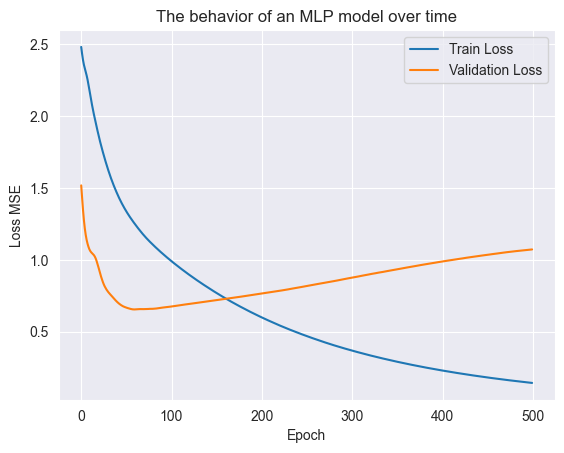

In [18]:
train_losses, val_losses = train_mlp(embeddings, ratings)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MSE')
plt.legend()
plt.title('The behavior of an MLP model over time')
plt.show()

# The impact of *learning rate* on results

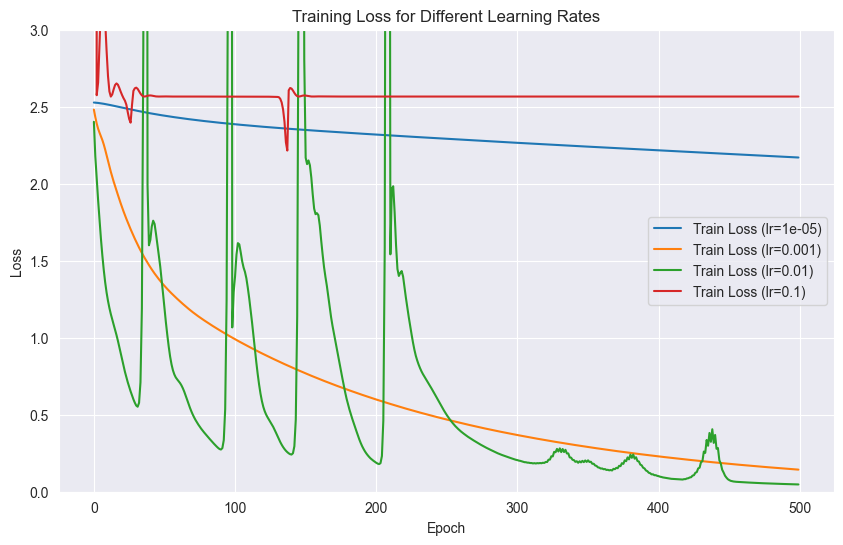

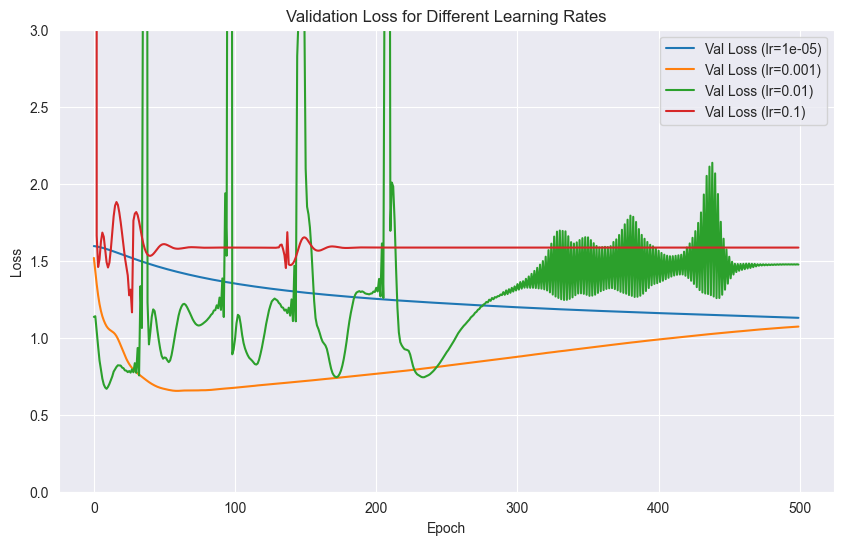

In [19]:
learning_rates = [0.00001, 0.001, 0.01, 0.1]
loss_dict = {}
for lr in learning_rates:
    train_losses, val_losses = train_mlp(embeddings, ratings, learning_rate_init=lr)
    loss_dict[lr] = (train_losses, val_losses)

plt.figure(figsize=(10, 6))
for lr, losses in loss_dict.items():
    train_losses, _ = losses
    plt.plot(train_losses, label=f'Train Loss (lr={lr})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss for Different Learning Rates')
plt.ylim(0, 3)
plt.show()


plt.figure(figsize=(10, 6))
for lr, losses in loss_dict.items():
    _, val_losses = losses
    plt.plot(val_losses, label=f'Val Loss (lr={lr})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss for Different Learning Rates')
plt.ylim(0, 3)
plt.show()

# The impact of *hidden size* on results


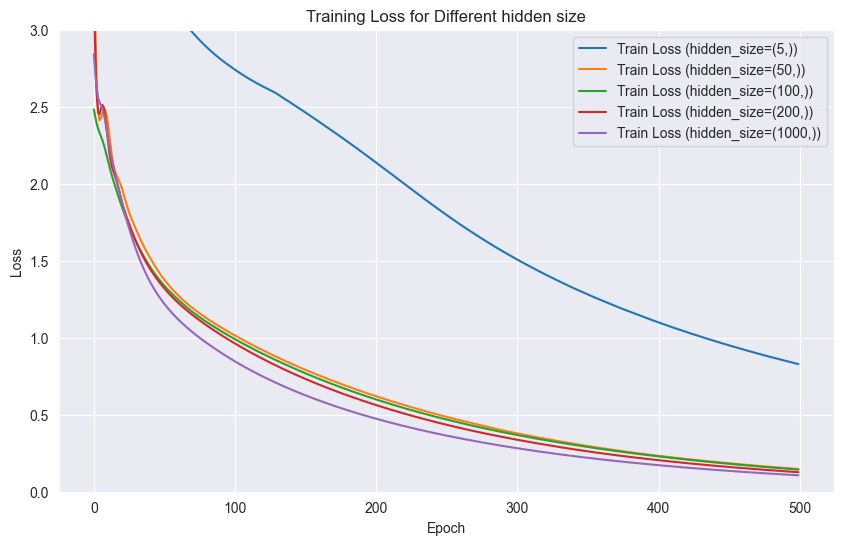

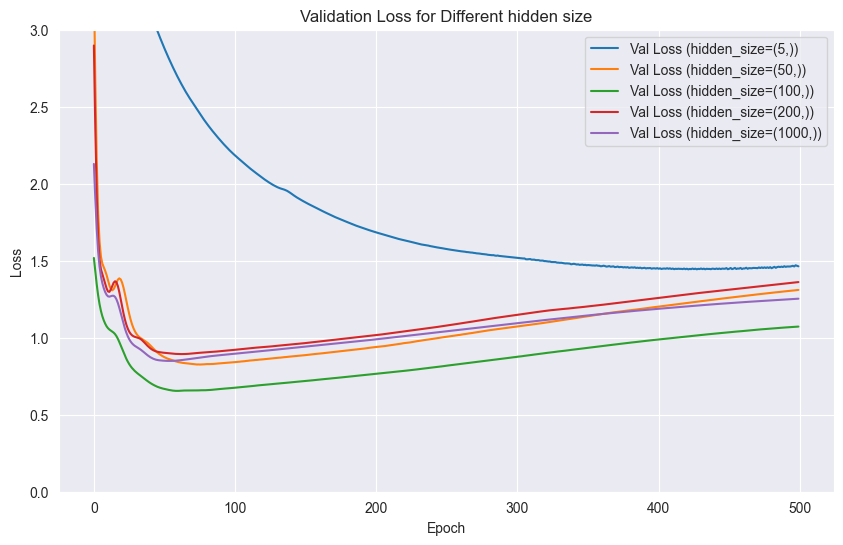

In [20]:
hidden_sizes = [(5,), (50,), (100,), (200,), (1000,)]
loss_dict = {}

for hidden_size in hidden_sizes:
    train_losses, val_losses = train_mlp(embeddings, ratings, hidden_layer_sizes=hidden_size)
    loss_dict[hidden_size] = (train_losses, val_losses)

plt.figure(figsize=(10, 6))
for hidden_size, losses in loss_dict.items():
    train_losses, _ = losses
    plt.plot(train_losses, label=f'Train Loss (hidden_size={hidden_size})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss for Different hidden size')
plt.ylim(0, 3)
plt.show()


plt.figure(figsize=(10, 6))
for hidden_size, losses in loss_dict.items():
    _, val_losses = losses
    plt.plot(val_losses, label=f'Val Loss (hidden_size={hidden_size})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss for Different hidden size')
plt.ylim(0, 3)
plt.show()

# Test on own jokes

In [21]:
my_jokes = [
    "Why don't scientists trust atoms? Because they make up everything!",
    "Why did the scarecrow win an award? Because he was outstanding in his field!",
    "I used to play piano by ear, but now I use my hands.",
    "Why did the scarecrow win an award? Because he was outstanding in his field!",
    "Why don't you ever see elephants hiding in trees? Because they're really good at it!",
    "Why don't oysters donate to charity? Because they are shellfish!",
    "Did you hear about the mathematician who's afraid of negative numbers? He'll stop at nothing to avoid them!",
    "Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum"
]

my_jokes_embeddings = model.encode(my_jokes)

In [22]:
best_estimator = MLPRegressor(
        solver='sgd',
        alpha=0.0,
        learning_rate='constant',
        learning_rate_init=0.001,
        hidden_layer_sizes=(100,),
        random_state=RANDOM_STATE
)

for _ in range(100):
    best_estimator.partial_fit(embeddings, ratings)

y = best_estimator.predict(my_jokes_embeddings)
for joke, rate in zip(my_jokes, y):
    print(f"Rating {rate}: {joke}")

Rating -0.44216233491897583: Why don't scientists trust atoms? Because they make up everything!
Rating -0.4597337245941162: Why did the scarecrow win an award? Because he was outstanding in his field!
Rating -0.5650926232337952: I used to play piano by ear, but now I use my hands.
Rating -0.4597337245941162: Why did the scarecrow win an award? Because he was outstanding in his field!
Rating 0.0818813145160675: Why don't you ever see elephants hiding in trees? Because they're really good at it!
Rating -0.18995803594589233: Why don't oysters donate to charity? Because they are shellfish!
Rating 0.25981634855270386: Did you hear about the mathematician who's afraid of negative numbers? He'll stop at nothing to avoid them!
Rating 1.6610400676727295: Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lorem ipsum Lore

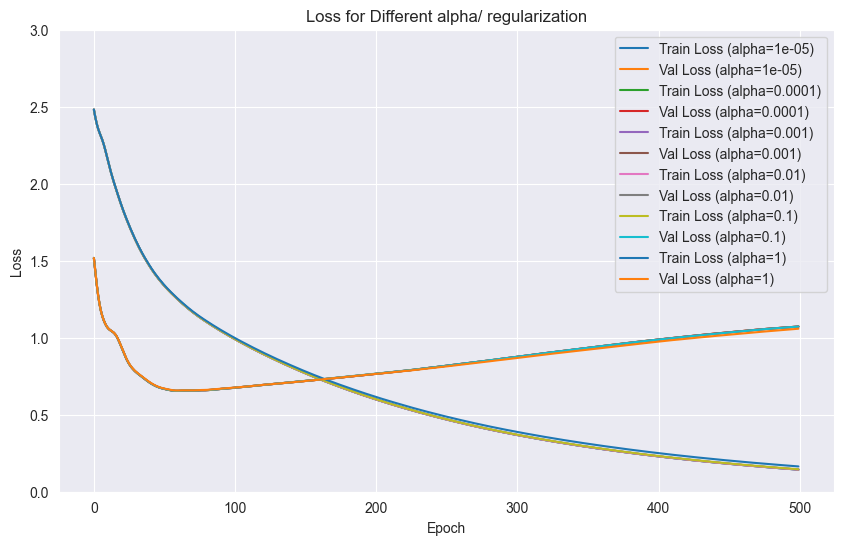

In [23]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
loss_dict = {}

for alpha in alphas:
    train_losses, val_losses = train_mlp(embeddings, ratings, alpha=alpha)
    loss_dict[alpha] = (train_losses, val_losses)

plt.figure(figsize=(10, 6))
for alpha, losses in loss_dict.items():
    train_losses, val_losses = losses
    plt.plot(train_losses, label=f'Train Loss (alpha={alpha})')
    plt.plot(val_losses, label=f'Val Loss (alpha={alpha})')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for Different alpha/ regularization')
plt.ylim(0, 3)
plt.show()
